<a href="https://colab.research.google.com/github/avitalkras/Deep-Learning-Project/blob/main/Code_Tutorial_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Part 1: Notebooks**

A notebook is useful to write code, document, and visualizations all in the same file, widely used in data science.

Google Colab hosts these notebooks, easy to use and share, and can use a free GPU.

The main DL library we use is PyTorch, along with NumPy to represent vectors, matrices and tensors.

In [ ]:
import torch #imports PyTorch

We will learn the basics of PyTorch. Relevant API objects are `torch`, `torch.nn`, `torch.nn.functional`, and `torch.Tensor`




In [ ]:
x = torch.tensor([1.0, 2.0, 3.0, 4.0]) #similiar to numpy.ndarray

x

tensor([1., 2., 3., 4.])

In [ ]:
import numpy as np
x_np = np.array([1.0, 2.0, 3.0, 4.0], dtype=np.float32)
x = torch.from_numpy(x_np)

x_np[0] = 100.0
x[1] = 200.0

print(f"x (NumPy): {x_np}")
print(f"x (Torch): {x}")

x (NumPy): [100. 200.   3.   4.]
x (Torch): tensor([100., 200.,   3.,   4.])


In [ ]:
x.shape

torch.Size([4])

In [ ]:
x.reshape(-1, 1)

tensor([[100.],
        [200.],
        [  3.],
        [  4.]])

In [ ]:
x.reshape(-1,2)

tensor([[100., 200.],
        [  3.,   4.]])

In [ ]:
x.reshape(-1, 1).shape #-1 tells PyTorch to infer the shape from the other dimensions

torch.Size([4, 1])

In [ ]:
# Broadcasting
print(x.shape)
x.reshape(-1, 1) + x

torch.Size([4])


tensor([[200., 300., 103., 104.],
        [300., 400., 203., 204.],
        [103., 203.,   6.,   7.],
        [104., 204.,   7.,   8.]])

In [ ]:
# Dot product
x @ x.T

tensor(50025.)

PyTorch - GPU support
We can move PyTorch tensors to the GPU, which allows us to perform some computations much faster.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [ ]:
x = x.to(device=device)

x

tensor([100., 200.,   3.,   4.], device='cuda:0')

In [ ]:
x @ x.T

tensor(50025., device='cuda:0')

## Basic Models

### Linear Regression

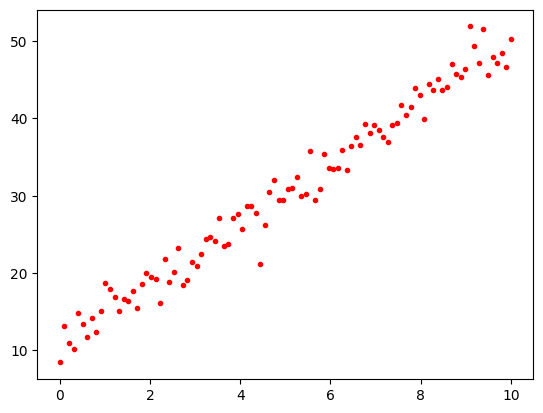

In [ ]:
import numpy.random as npr
import matplotlib.pyplot as plt
# In our synthetic data, we have w = 4 and b = 10
N = 100  # Number of training data points
x = np.linspace(0, 10, N)

t = 4 * x + 10 + npr.normal(0, 2, x.shape[0])
plt.plot(x, t, "r.")

x = torch.from_numpy(x)
t = torch.from_numpy(t)

In [ ]:
# Initialize random parameters
params = {
    "w": torch.randn(1).requires_grad_(True),
    "b": torch.randn(1).requires_grad_(True)}

def cost(params):
    y = params["w"] * x + params["b"]
    return (1 / N) * torch.sum(0.5 * (y - t) ** 2)


# Find the gradient of the cost function using pytorch
num_epochs = 1000  # Number of epochs of training
alpha = 0.01  # Learning rate

# Store parameters and loss for plotting
param_history = []
loss_history = []

for i in range(num_epochs):
    # Evaluate the gradient of the current parameters stored in params
    loss = cost(params)
    loss.backward()

    if i % 100 == 0:
        print(f"Iteration {i} = {i:<5d} Loss: {loss.item():.4f}")

    if i % 10 == 0:
        param_history.append({
            "w": params["w"].data.numpy().copy(),
            "b": params["b"].data.numpy().copy()
        })
        loss_history.append(loss.item())


    # Update parameters w and b (since you are not computing gradients, let torch know so its faster)
    with torch.no_grad():
        params["w"].data = params["w"] - alpha * params["w"].grad
        params["b"].data = params["b"] - alpha * params["b"].grad
        params["w"].grad.zero_()
        params["b"].grad.zero_()
        #zero gradients (relevant for SGD where gradients accumulate across minibatches)

print(params)

Iteration 0 = 0     Loss: 752.3208
Iteration 100 = 100   Loss: 13.0713
Iteration 200 = 200   Loss: 8.6261
Iteration 300 = 300   Loss: 5.9218
Iteration 400 = 400   Loss: 4.2767
Iteration 500 = 500   Loss: 3.2760
Iteration 600 = 600   Loss: 2.6671
Iteration 700 = 700   Loss: 2.2968
Iteration 800 = 800   Loss: 2.0715
Iteration 900 = 900   Loss: 1.9344
{'w': tensor([4.0900], requires_grad=True), 'b': tensor([9.6694], requires_grad=True)}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# If using PyTorch tensors, detach & convert once:
X = x.detach().cpu().numpy() if hasattr(x, "detach") else np.asarray(x)
T = t.detach().cpu().numpy() if hasattr(t, "detach") else np.asarray(t)

# Prepare figure/artists
fig, ax = plt.subplots(figsize=(6,4))
ax.set_xlabel("x"); ax.set_ylabel("t")
ax.set_title("Linear Regression Learning Process")
ax.scatter(X, T, c="r", s=16, label="Data")

# Create an initial regression line artist
line, = ax.plot([], [], "b-", lw=2, label="Model y = w x + b")
ax.legend(loc="best")

# Fix axes so they don't jump around during training
pad_x = 0.05 * (X.max() - X.min() if X.max() > X.min() else 1.0)
pad_y = 0.05 * (T.max() - T.min() if T.max() > T.min() else 1.0)
ax.set_xlim(X.min() - pad_x, X.max() + pad_x)
ax.set_ylim(T.min() - pad_y, T.max() + pad_y)

# For a clean line, sort by X once
order = np.argsort(X)
X_sorted = X[order]

def init():
    line.set_data([], [])
    return (line,)

def update(i):
    # Extract scalars (handles tensors and numpy)
    w = param_history[i]["w"]
    b = param_history[i]["b"]
    w = float(w.item() if hasattr(w, "item") else w)
    b = float(b.item() if hasattr(b, "item") else b)

    Y_sorted = w * X_sorted + b
    line.set_data(X_sorted, Y_sorted)
    ax.set_title(f"Linear Regression Learning Process — Iteration {i}")
    return (line,)

# If you want fewer frames, use frames=range(0, len(param_history), step)
ani = animation.FuncAnimation(
    fig, update, init_func=init,
    frames=len(param_history), interval=100, blit=True
)

# Show inline (no need to save first)
plt.close(fig)  # prevent duplicate static figure
HTML(ani.to_jshtml())